# Projet OpenClassroom 5: Segmentez les comportements de clients #

## Introduction à notre problématique ##






### Problématique client et présentation des étapes de notre travail :  ### 

Notre travail consiste au sein d'une équipe marketing à mieux comprendre le comportement de clients de l'entreprise afin que celle-ci puisse adapter sa stratégie commerciale afin de maximiser la fréquence d'achat et d'augmenter son chiffre d'affaire. Notre travail se focalisera sur la compréhension du comportement des clients dans la durée afin de détecter ceux qui sont le plus susceptible de passer à l'achat. Nous disposons pour cela d'une année de transactions datant du 01/12/2010 au 09/12/2011 disponible depuis le site de l'[UCI](https://archive.ics.uci.edu/ml/datasets/Online+Retail).

Quelques notions concernant la segmentation client (explication prise du livre "Introduction générale à la gestion" de François Cocula): 

Ce que nous allons effectué ici est une tentative de segmentation client basée sur les caractéristiques clients que nous pourrons dégager de notre analyse des données.Segmenter une clientèle consiste à le découper en sous-ensembles homogènes, chacun de ses segments pouvant être choisi comme une cible à atteindre par une politique commerciale spécifique.
Réussir une segmentation impose certaines conditions:
 - la segmentation se révèle pertinente si les segments différents les uns des autres suivant des critères pertinents.
 - ces segments ne doivent pas non plus être trop nombreux car il est difficile pour une entreprise de suivre plusieurs politique commerciales simultanéments.
 
Quatre principaux critères peuvent être utilisés:
- critères géographiques (zone d'habitation)
- socio-démographiques (âge, revenu...)
- comportementaux (fidélité à la marque, taux d'utilisation...)
- psychographiques (style de vie, personnalité..).

Nous ne focaliserons ici sur les critères démographiques (pays d'achat) et sur les critères comportementaux à travers l'utilisation du concept de RFM.



### Importation des librairies python nécessaires à notre travail :  ### 

In [4]:
## Librairie standard : 

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='once')
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import datetime, date, timedelta

## Librairie sklearn :

from sklearn import preprocessing, cluster, metrics
from sklearn import tree
from sklearn import model_selection

##A effacer
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

## Librairie tierce : 
import graphviz

## Librairie personnelle : 

import plot_function

## I - Chargement des données et découverte des variables : ##


Ce jeu de données contient 8 features et 541909 lignes: chacune des lignes correspond à un article d'une transaction (plusieurs articles composent un achat). On dispose de 8 features à savoir : le numéro de facture, le code article en stock, la description synthétique de l'article, la quantité commandée pour l'article, la date de facture, le prix, un identifiant du client et le pays de résidence du client.



In [5]:
table_raw = pd.read_excel("Online Retail.xlsx")

In [6]:
table_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


**Tableau 001 :** Aperçu du contenu de notre jeu de données. 

## II - Nettoyage des variables sélectionnées et featuring: ##

 ###  Observation du taux de remplissage des données à notre disposition :  ###

On observe tout d'abord que la feature CustomerID possède de nombreuses valeurs nulles, nous allons d'abord supprimer ces valeurs car des transactions sans client ne sont pas intéressantes dans le cadre de notre étude.

In [7]:
print(f"\n Nombre de valeurs manquantes par features: \n")
table_raw.isnull().sum()


 Nombre de valeurs manquantes par features: 



InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [8]:
table_travail = table_raw.copy()

In [9]:
table_travail.dropna(axis=0, subset=['CustomerID'],
                     how='any', inplace=True)

### Cas de la feature InvoiceNo : ###

En observant les données contenus dans la variable "InvoiceNo" on s'aperçoit que certaines transactions commencent par c ce qui indique que ces transactions ont été annulées, nous allons supprimer ces transactions de notre jeu de données à condition qu'ils ne s'agissent pas de transactions de type discount que nous exploiterons par la suite.

In [10]:
for ind, val in table_travail.iterrows():
    if (table_travail.at[ind, 'StockCode'] == 'D'):
        table_travail.at[ind, 'InvoiceNo'] = \
        str(table_travail.at[ind, 'InvoiceNo']).replace('C', 'D')

In [11]:
table_travail['InvoiceNo'] = \
table_travail['InvoiceNo'].apply(lambda x: np.nan
                                 if str(x).lower().startswith('c')
                                 else str(x))
table_travail.dropna(axis=0, inplace=True, subset=['InvoiceNo'], how='any')

### Cas de la feature StockCode :  ###

La variable StockCode semble contenir un code article identifiant un objet mais également des informations sur la commande passée comme des frais de port ou des frais de banques. La liste de ces codes numériques présent dans la variable StockCode est affichée ci-dessous. Nous conserverons ces éléments dans notre jeu de données, celle-ci faisant partie des commandes clients.


In [12]:
table_travail["StockCode"] = \
    table_travail["StockCode"].apply(lambda x: str(x).upper())

In [13]:
table_travail[["StockCode", "Description"]].sort_values(["StockCode"])\
                                           .drop_duplicates()\
                                           .tail(7)

,StockCode,Description
175275,BANK CHARGES,Bank Charges
169529,C2,CARRIAGE
516221,D,Discount
401766,DOT,DOTCOM POSTAGE
489058,M,Manual
157195,PADS,PADS TO MATCH ALL CUSHIONS
86963,POST,POSTAGE


** Tableau 002 : ** Liste des mots particuliers présent dans la variable StockCode indiquant des frais divers liés à l'achat. Ces frais divers peuvent caractériser le comportement de certains clients, ce pouquoi nous conserverons certaines de ses valeurs afin de créer certaines features.

Nous allons nous assurer que l'ensemble du contenu de la feature "StockCode" est de type str.

In [14]:
table_travail["StockCode"] = \
    table_travail["StockCode"].apply(lambda x: str(x).upper())

### Traitement des variables Quantity et CustomerID: ###

Nous allons nous assurer que les features Quantity et CustomerID contiennent bien des entiers.

In [15]:
table_travail["Quantity"] = \
    table_travail["Quantity"].apply(lambda x: int(x))
table_travail["CustomerID"] = \
    table_travail["CustomerID"].apply(lambda x: int(x))

### Création de la feature Amount produit de "UnitPrice" par "quantity":  ###

Nous allons tout simplement faire le produit de "quantity" par "UnitPrice" afin d'obtenir le montant des achats par produit.

In [16]:
table_travail["Amount"] = table_travail["Quantity"] * \
    table_travail["UnitPrice"]

### Création de la feature Is_Discount indiquant si une transaction a fait l'objet d'un discount: ###

In [17]:
table_travail["Discount"] = \
    table_travail["StockCode"].apply(lambda x: 1 if x == "D" else 0)

### Création de la feature POST indiquant si une transaction a fait l'objet de frais postaux: ###

In [18]:
table_travail["POST"] = \
    table_travail["StockCode"].apply(lambda x: 1 if x == "POST" else 0)

### Création de la feature MANUAL si l'objet a été retiré à la main: ###

In [19]:
table_travail["Manual"] = \
    table_travail["StockCode"].apply(lambda x: 1 if x == "M" else 0)

## Traitement des outliers de notre jeu de données: ##

Nous allons exclure de notre jeu de données les valeurs extrêmes qui sont des cas réels de clients qu'il faudra traiter à part. Conserver ces clients dans notre jeu de données nous ne permettra pas d'observer proprement notre jeu de données et nuira à nos tentatives de segmentation clients (algorithme K-means sensible aux outliers).

In [20]:
table_travail.describe()

,Quantity,UnitPrice,CustomerID,Amount,Discount,POST,Manual
count,398001.000000,398001.000000,398001.000000,398001.000000,398001.000000,398001.000000,398001.000000
mean,13.016304,3.129595,15294.244075,22.376104,0.000193,0.002761,0.000729
std,180.407158,22.322308,1713.090523,309.043405,0.013908,0.052476,0.026984
min,-720.000000,0.000000,12346.000000,-1867.860000,0.000000,0.000000,0.000000
25%,2.000000,1.250000,13969.000000,4.680000,0.000000,0.000000,0.000000
50%,6.000000,1.950000,15159.000000,11.800000,0.000000,0.000000,0.000000
75%,12.000000,3.750000,16795.000000,19.800000,0.000000,0.000000,0.000000
max,80995.000000,8142.750000,18287.000000,168469.600000,1.000000,1.000000,1.000000


** Tableau 002: ** Résumé statistique de nos features de type numérique. Les features Amount, Quantity et UnitPrice possèdent des outliers, nous allons conserver uniquement les données inférieurs au 99ième quantile. 

In [21]:
limit1 = table_travail["Amount"] \
         .describe(percentiles=[0.25, 0.5, 0.99])["99%"]
limit2 = table_travail["Quantity"] \
         .describe(percentiles=[0.25, 0.5, 0.99])["99%"]
limit3 = table_travail["UnitPrice"] \
         .describe(percentiles=[0.25, 0.5, 0.99])["99%"]

In [22]:
table_travail = table_travail[table_travail["Amount"] < limit1]
table_travail = table_travail[table_travail["Quantity"] < limit2]
table_travail = table_travail[table_travail["UnitPrice"] < limit3]

### Création de la feature Is_UK pour déterminer les clients originaires du Royaume Uni : ##

Nous observons 37 catégories de pays dans la feature "Country". Nous allons créer une variable Is_UK afin de distinguer les clients du Royaume-Uni des autres clients. 

In [23]:
print(f"Les clients proviennent de " 
      f"{len(table_travail['Country'].unique())}"
      f" pays différents.")

Les clients proviennent de 37 pays différents.


In [24]:
table_travail["Is_UK"] = \
    table_travail["Country"].apply(lambda x: 1 if x == "United Kingdom" 
                                   else 0)

### Création de la feature Year_Month contenant le mois et l'année de la transaction: ##

Nous allons stocké dans une variable Year_Month l'année et le mois de la transaction afin de l'utiliser par la suite lors de notre étape de clustering.

In [25]:
table_travail["Year_Month"] = \
    table_travail["InvoiceDate"].apply(lambda x: f"{x.year}_{x.month}")

## III - Analyse Exploratoire: ##

Nous allons maintenant procéder à l'étape d'exploration de nos données afin de mieux comprendre ce qui contient notre jeu de données. Nous allons dans un premier temps nous intéresser:

- aux achats effectués sur ce site (le prix  des articles, le prix des achats effectués).
- aux achats par pays.
- aux ventes par mois.
- aux meilleurs clients.
- aux meilleurs articles vendus.

Nous ferons un premier bilan de cette analyse exploratoire.

In [26]:
df = table_travail.groupby(["CustomerID","InvoiceDate"]).sum()["Amount"]
pd.DataFrame(df.describe().values.reshape(1,-1), columns=df.describe().index)

,count,mean,std,min,25%,50%,75%,max
0,17714.0,356.857541,415.740196,-67.2,143.555,273.03,421.8525,7863.27


** Tableau 003: ** Statistiques descriptives des montants des transactions effectuées dans notre jeu de données. Nous pouvons donc voir qu'il y a eu 17714 transactions dans notre jeu de données pour un montant moyen de transactions clients de 356,85 pounds. Un client a depensé à lui seul 7863 pounds au cours d'une transaction.

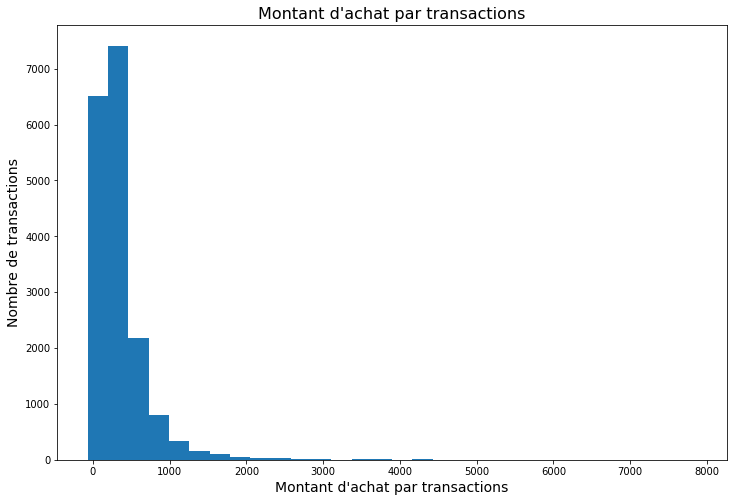

In [27]:
fig = plt.figure(figsize=(12, 8))

plt.hist(table_travail.groupby(["CustomerID","InvoiceDate"]).sum()["Amount"], bins=30)
plt.ylabel("Nombre de transactions", fontsize=14)
plt.xlabel("Montant d'achat par transactions", fontsize=14)
plt.title("Montant d'achat par transactions", fontsize=16)
plt.show()

** Figure 001 : ** Représentation de la distribution des montants d'achats par transaction. On voit que la plupart des transactions représente des achats de l'ordre de quelques centaines de pounds.

In [28]:
df2 = table_travail.groupby(["CustomerID","InvoiceDate"]).sum()["Quantity"]
pd.DataFrame(df2.describe().values.reshape(1,-1), columns=df2.describe().index)

,count,mean,std,min,25%,50%,75%,max
0,17714.0,208.615897,256.709401,-720.0,71.25,144.0,260.0,5663.0


** Tableau 004: ** Statistiques descriptives des quantités d'articles achetés par transaction. Les quantités négatives représentent les achats à prix discount. Le nombre moyen d'articles achetés par transaction est de l'ordre de 200.

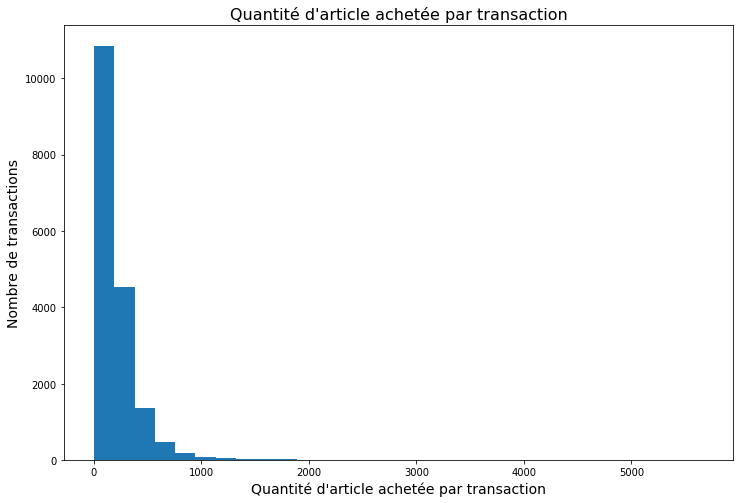

In [29]:
fig = plt.figure(figsize=(12, 8))
table_plot = table_travail[table_travail["Quantity"] > 0]
plt.hist(table_plot.groupby(["CustomerID","InvoiceDate"]).sum()["Quantity"], bins=30)
plt.ylabel("Nombre de transactions", fontsize=14)
plt.xlabel("Quantité d'article achetée par transaction", fontsize=14)
plt.title("Quantité d'article achetée par transaction", fontsize=16)
plt.show()

** Figure 002 ** : Représentation de la distribution des quantités d'article achetés par transaction. 

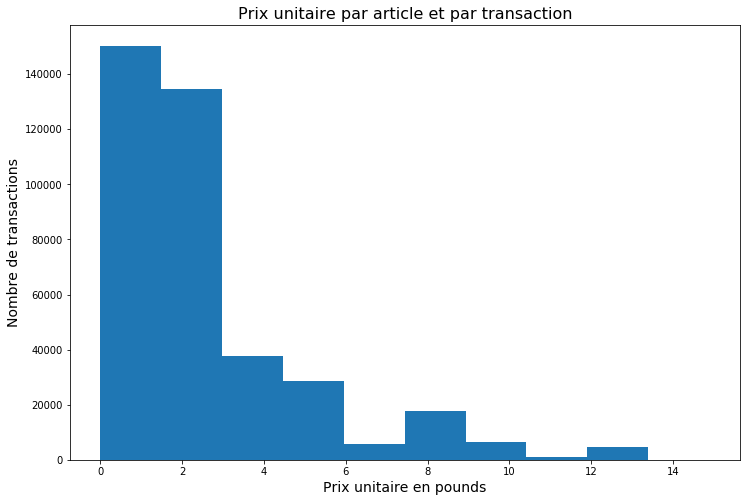

In [30]:
fig = plt.figure(figsize=(12, 8))
plt.hist(table_travail["UnitPrice"], histtype='bar')
plt.ylabel("Nombre de transactions", fontsize=14)
plt.xlabel("Prix unitaire en pounds", fontsize=14)
plt.title("Prix unitaire par article et par transaction", fontsize=16)
plt.show()

** Figure 003 ** : Distribution unitaire par article et par transaction. Il s'agit ici d'article en majorité de faibles valeurs unitaires.

C:\Users\BIENVENUE\Python\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


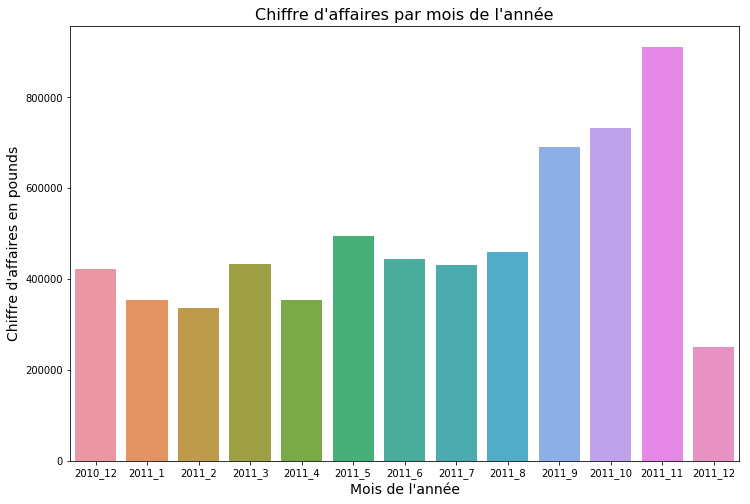

In [31]:
fig = plt.figure(figsize=(12, 8))
dt = table_travail.groupby(by=["Year_Month"])[["Amount"]].sum()
dt.reset_index(inplace=True)
dt["Year"] = dt["Year_Month"].apply(lambda x: int(x.split("_")[0]))
dt["Month"] = dt["Year_Month"].apply(lambda x: int(x.split("_")[1]))
dt.sort_values(by=["Year","Month"], inplace=True)
sns.barplot(x="Year_Month", y="Amount", 
            data=dt, order=list(dt["Year_Month"]))
plt.xlabel("Mois de l'année", fontsize=14)
plt.ylabel("Chiffre d'affaires en pounds", fontsize=14)
plt.title("Chiffre d'affaires par mois de l'année", fontsize=16)
plt.show()

** Figure 004 ** : On observe une forte progression des ventes sur la fin de la période du jeu de données.

In [32]:
ca = table_travail.groupby(by=["Year_Month"])[["Amount"]] \
                  .sum() \
                  .sum()["Amount"]
print(f"Le chiffre d'affaire sur la période considérée est de " +
      "%.0f"%ca +" pounds.")


Le chiffre d'affaire sur la période considérée est de 6321374 pounds.


Le chiffre d'affaire sur la période observée est donc de l'ordre de 6,3 millions de pounds.

C:\Users\BIENVENUE\Python\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


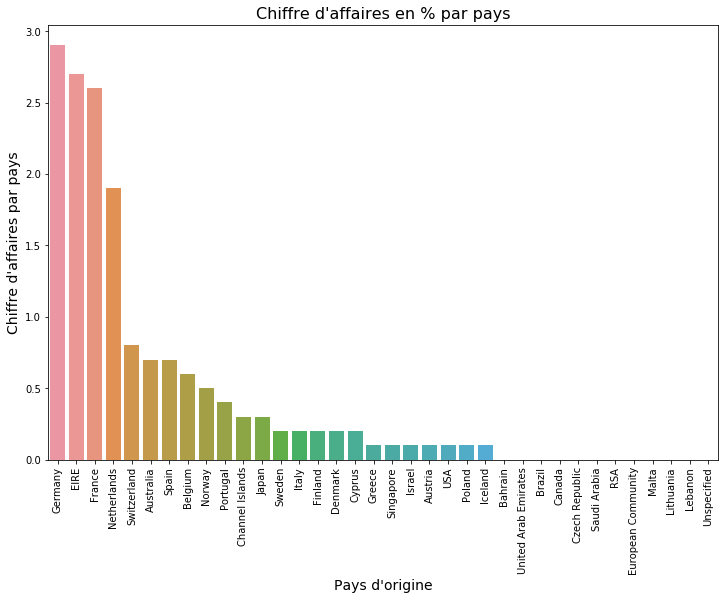

In [54]:
fig = plt.figure(figsize=(12, 8))
dt = table_travail.groupby(by=["Country"])[["Amount"]].sum()
dt["% of sales"] = \
dt["Amount"].apply(lambda x: round(x / dt.Amount.sum(), 3) * 100)
dt.reset_index(inplace=True)
dt.sort_values(by=["% of sales"], inplace=True, ascending=False)
sns.barplot(y="% of sales", x="Country",
            data=dt[1:], order=list(dt[1:]["Country"]))

plt.xlabel("Pays d'origine", fontsize=14)
plt.xticks(rotation=90)
plt.ylabel("Chiffre d'affaires par pays", fontsize=14)
plt.title("Chiffre d'affaires en % par pays", fontsize=16)
plt.show()

** Figure 005:** Répartition du chiffre d'affaires par pays (en dehors de UK qui représente 84% du CA).

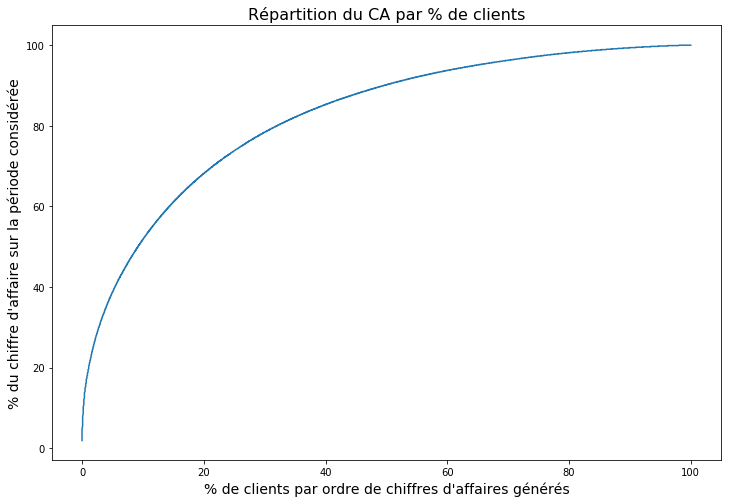

In [34]:
fig = plt.figure(figsize=(12, 8))
dt = table_travail.groupby(by=["CustomerID"])[["Amount"]] \
                  .sum() \
                  .sort_values("Amount",ascending = False)
dt.reset_index(inplace=True)
dt["% cumulé client"] = dt.index
dt["% cumulé client"] = dt["% cumulé client"] / dt["% cumulé client"].max() * 100
dt["% cumulé client"] = dt["% cumulé client"].apply(lambda x: round(x, 1))
dt["AmountSum"] = dt["Amount"].cumsum().apply(lambda x: round(x/ca*100, 1))
plt.plot(dt["% cumulé client"],dt["AmountSum"])

plt.xlabel("% de clients par ordre de chiffres d'affaires générés", fontsize=14)
plt.ylabel("% du chiffre d'affaire sur la période considérée", fontsize=14)
plt.title("Répartition du CA par % de clients", 
          fontsize=16)
plt.show()

** Figure 006:** Répartition du chiffre d'affaires par clients. On peut clairement voir que tous les clients sur les 4271 ne se valent pas en termes de chiffres d'affaires. On voit en effet que la règle de Pareto est presque respectée, un peu plus de 30 % des clients représentent 80% du chiffre d'affaires. Ces clients sont donc particulièrement important.

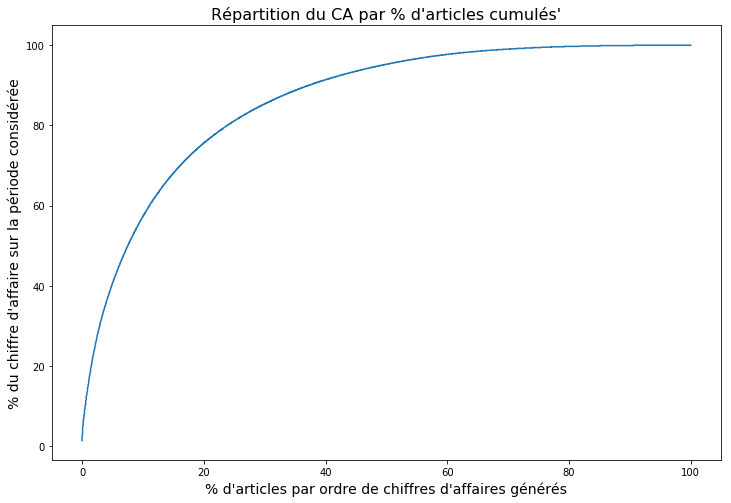

In [35]:
fig = plt.figure(figsize=(12, 8))
dt = table_travail.groupby(by=["StockCode"])[["Amount"]] \
                  .sum() \
                  .sort_values("Amount",ascending = False)
dt.reset_index(inplace=True)
dt["% cumulé article"] = dt.index
dt["% cumulé article"] = dt["% cumulé article"] / dt["% cumulé article"].max() * 100
dt["% cumulé article"] = dt["% cumulé article"].apply(lambda x: round(x, 1))
dt["AmountSum"] = dt["Amount"].cumsum().apply(lambda x: round(x / ca*100, 1))
plt.plot(dt["% cumulé article"],dt["AmountSum"])

plt.xlabel("% d'articles par ordre de chiffres d'affaires générés", fontsize=14)
plt.ylabel("% du chiffre d'affaire sur la période considérée", fontsize=14)
plt.title("Répartition du CA par % d'articles cumulés'", 
          fontsize=16)
plt.show()

** Figure 006:** Répartition du chiffre d'affaires par article. Un peu plus de 23% des articles(sur un total de 3610) générent 80% des ventes.

### Conclusion de notre analyse exploratoire de données : ###

Nous avons pu à travers cette première exploration mieux comprendre notre jeu de données et les natures des transactions. Ces transactions sont faites en très grande majorité (84%) par des clients du Royaume-Uni. La panier moyen est de l'ordre de 350 pounds pour une quantité d'article moyenne acheté de 200. La valeur moyenne des articles proposée sur le site est donc faible. Nous avons également vu que 80% du chiffre d'affaires de l'entreprise était réalise par un peu plus de 30 % des clients.

Afin de continuer à explorer le comportement de nos clients, nous allons maintenant construire le tableau RFM qui nous donnera des informations complémentaires sur nos clients.


## Construction d'un tableau dérivé du modèle RFM :##

Afin d'étudier le comportement des clients, nous allons transformer notre jeu de données afin de construire des features caractérisant le comportement de chacun des clients. Nous nous inspirerons de l'approche marketing basé sur la récence des achats (R), la fréquence des achats (F) ainsi que le montant d'achat total (M). Nous compléterons ce tableau RFM par d'autres features caractéristiques de notre jeu de données. 

### Création d'une table de hachage AMOUNT du montant total des transactions  : ###

Nous allons créer une table de hachage ayant comme clé "CustomerID" avec le total des dépenses effectuées sur la période considérée.

In [36]:
tab_hash_amount = table_travail.groupby(["CustomerID"]).sum()["Amount"]

### Création d'une table de hachage AMOUNT_first du montant de la première transaction: ###


De même, nous créérons une seconde table de hachage ayant comme clé "CustomerID" avec le total des dépenses effectuées au premier achat.

In [37]:
tab_hash_amount_first = table_travail.sort_values(["InvoiceDate"]) \
                                     .groupby(["InvoiceDate", "CustomerID"]) \
                                     .sum()["Amount"]
 
tab_hash_amount_first = tab_hash_amount_first.reset_index() \
                                             .drop_duplicates(["CustomerID"])
tab_hash_amount_first.set_index(["CustomerID"], inplace=True)
tab_hash_amount_first.drop(["InvoiceDate"], axis=1, inplace=True)

### Création d'une table de hachage contenant les caractéristiques d'achat :##

Nous allons ajouter à cette table RFM, certains features de notre jeu de données décrivant le comportement d'un client afin de mieux prendre en compte ses caractéristiques et mieux expliquer la segmentation ainsi obtenue. Nous incluerons donc dans cette table RFM le nombre de discount reçu par client, le nombre de transactions avec frais de port ou retiré manuellement. Nous compléterons également cette table avec un résumé des transactions effectuées: quantité minimale acheté, maximale et moyenne. Nous ferons de même avec le prix moyen et les montants.

In [38]:
tab_hash_features = table_travail.groupby(["CustomerID"]) \
                                 .agg({'Discount':['sum'],
                                       'POST':['sum'],
                                       'Manual':['sum']})

In [39]:
tab_hash_other = table_travail.groupby(["CustomerID", "InvoiceDate"]) \
                              .agg({"Quantity": ['min', 'max', 'mean'],
                                    "UnitPrice": ['min', 'max', 'mean'],
                                    "Amount": ['min', 'max', 'mean']}) \
                              .groupby(["CustomerID"]) \
                              .mean()

### Création d'une table de hachage FREQUENCE concernant la fréquence d'achat sur la période considérée  : ###

Nous allons créer une table de hachage reliant la clé "CustomerID" avec la fréquence d'achat du client sur la période considérée.

In [40]:
tab_hash_freq = table_travail[["InvoiceDate", "CustomerID"]] \
                    .drop_duplicates() \
                    .groupby(["CustomerID"]) \
                    .count()["InvoiceDate"]

### Création d'une table de hachage RECENCY concernant la distance par rapport à la date du dernier achat : ###

Nous allons créer une table de hachage reliant cla lé "CustomerID" avec la distance en jours au dernier achat effectué par le client.

In [41]:
tab_hash_recency = table_travail[["InvoiceDate",
                                  "CustomerID", 
                                  "Amount", 
                                  "Is_UK"]].drop_duplicates()
tab_hash_recency.sort_values(["InvoiceDate"], ascending=False, inplace=True)
tab_hash_recency.drop_duplicates(["CustomerID"], inplace=True)

In [42]:
date_ref = datetime(2011, 12, 9)
tab_hash_recency["Recency"] = \
    tab_hash_recency["InvoiceDate"].apply(lambda x: abs((x - date_ref).days))
tab_hash_recency = tab_hash_recency.set_index(["CustomerID"])

### Création d'une table de hachage LATENCY concernant la distance par rapport à la date du premier achat : ###

Nous allons créer une table de hachage reliant l'identifiant "CustomerID" avec la distance en jours au premier achat sur la période considérée.

In [43]:
tab_hash_latency = table_travail[["InvoiceDate", 
                                  "CustomerID"]].drop_duplicates()
tab_hash_latency.sort_values(["InvoiceDate"], ascending=True, inplace=True)
tab_hash_latency.drop_duplicates(["CustomerID"], inplace=True)

In [44]:
date_ref = datetime(2011, 12, 9)
tab_hash_latency["Latency"] = \
    tab_hash_latency["InvoiceDate"].apply(lambda x: abs((x - date_ref).days))
tab_hash_latency = tab_hash_latency.set_index(["CustomerID"])["Latency"]

### Création de notre table RLFM: ###

En assemblant les différentes tables de hachage, nous allons ainsi construire notre table RFM étendue.

In [45]:
table_rfm = pd.DataFrame(index=tab_hash_recency.index, 
                         data=tab_hash_recency[["InvoiceDate", 
                                                "Recency",
                                                "Is_UK"]])

In [46]:
table_rfm["Key"] = table_rfm.index
table_rfm["Amount"] = \
    table_rfm["Key"].apply(lambda x: tab_hash_amount[x])
table_rfm["Amount_first"] = \
    table_rfm["Key"].apply(lambda x: 
                           tab_hash_amount_first["Amount"][x])
table_rfm["Frequency"] = \
    table_rfm["Key"].apply(lambda x: tab_hash_freq[x])
table_rfm["Latency"] = \
    table_rfm["Key"].apply(lambda x: tab_hash_latency[x])
table_rfm.drop(["Key"], axis=1, inplace=True)

In [47]:
table_rfm.head(5)

,InvoiceDate,Recency,Is_UK,Amount,Amount_first,Frequency,Latency
CustomerID,,,,,,,
12680,2011-12-09 12:50:00,0,0,790.81,275.78,4,113
13113,2011-12-09 12:49:00,0,1,6766.36,372.97,24,366
15804,2011-12-09 12:31:00,0,1,3907.54,525.36,13,198
13777,2011-12-09 12:25:00,0,1,9238.57,510.78,27,373
17581,2011-12-09 12:21:00,0,1,10621.14,668.40,23,372


** Figure 007: ** Aperçu du tableau RFM ainsi obtenu.


Nous obtenons ainsi le tableau RFM décrivant la récence d'un achat, la latence d'un achat, la fréquence d'achat sur l'année ainsi que le montant d'achat total sur la période considérée. La synthèse des résultats obtenus ci-dessous nous montre la présence d'outliers parmi les données qui nuiront à la qualité d'un clustering de type k-means sur nos données.

### Création de la feature MTBT (Mean Time Between Transactions): ###

Nous allons introduire en complément une feature MTBT représentant le temps moyen entre 2 achats d'un client.

In [48]:
table_rfm["MTBT"] = (table_rfm["Latency"] - table_rfm["Recency"]) \
                    / table_rfm["Frequency"]

In [49]:
table_rfm["MTBT"] = table_rfm["MTBT"].apply(lambda x: 0 if int(x) == 0 else x)

### Introduction de features complémentaires dans notre table RFM étendue :### 

Nous allons introduire dans la table RFM un certain nombre de features additionnelles définies plus haut.

In [50]:
table_rfm["Amount_mean"] = table_rfm["Amount"] / table_rfm["Frequency"]

In [51]:
table_rfm.reset_index(inplace=True)

In [52]:
t = table_rfm["CustomerID"]

In [53]:
table_rfm["QuantityMin"] = t.apply(lambda x: 
                                   tab_hash_other["Quantity", "min"][x])
table_rfm["QuantityMax"] = t.apply(lambda x: 
                                   tab_hash_other["Quantity", "max"][x])
table_rfm["QuantityMean"] = t.apply(lambda x: 
                                    tab_hash_other["Quantity", "mean"][x])
table_rfm["UnitPriceMin"] = t.apply(lambda x: 
                                    tab_hash_other["UnitPrice", "min"][x])
table_rfm["UnitPriceMax"] = t.apply(lambda x: 
                                    tab_hash_other["UnitPrice", "max"][x])
table_rfm["UnitPriceMean"] = t.apply(lambda x: 
                                     tab_hash_other["UnitPrice", "mean"][x])
table_rfm["AmountMin"] = t.apply(lambda x: 
                                 tab_hash_other["Amount", "min"][x])
table_rfm["AmountMax"] = t.apply(lambda x: 
                                 tab_hash_other["Amount", "max"][x])
table_rfm["AmountMean"] = t.apply(lambda x: 
                                  tab_hash_other["Amount", "mean"][x])
table_rfm["Discount"] = t.apply(lambda x: 
                                tab_hash_features["Discount", "sum"][x])
table_rfm["POST"] = t.apply(lambda x: 
                            tab_hash_features["POST", "sum"][x])
table_rfm["Manual"] = t.apply(lambda x: 
                              tab_hash_features["Manual", "sum"][x])

In [54]:
table_rfm.set_index(["CustomerID"], inplace=True)

### Traitement des outliers de notre table RLFM : ###

Une fois cette table RFM étendue définie, nous allons essayer de segmenter nos clients en appliquant sur ces données des algorithmes de clustering. Nous appliquerons un algorithme de type K means afin de trouver ce clustering. L'algorithme K-means étant sensible aux outliers, nous allons de nouveau les valeurs extrêmes des variables Frequency et Amount et conserver seulement les données inférieurs aux quantiles à 99%.

In [55]:
limitFreq = \
    table_rfm["Frequency"].describe(percentiles=[0.25, 0.5, 0.99])["99%"]
limitAmount = \
    table_rfm["Amount"].describe(percentiles=[0.25, 0.5, 0.99])["99%"]
table_rfm = table_rfm[table_rfm["Frequency"] < limitFreq]
table_rfm = table_rfm[table_rfm["Amount"] < limitAmount]


## Exploration des données de la table RFM obtenue: ##

### Analyse univariée des features principales :  ###

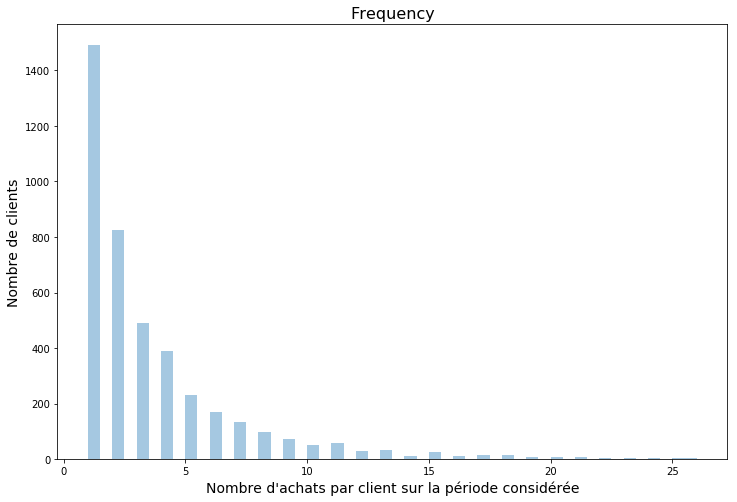

In [56]:
fig = plt.figure(figsize=(12, 8))
sns.distplot(table_rfm["Frequency"], kde=False, bins=50)
plt.ylabel("Nombre de clients", fontsize=14)
plt.xlabel("Nombre d'achats par client sur la période considérée", fontsize=14)
plt.title("Frequency", fontsize=16)
plt.show()

** Figure 008: ** Distribution du nombre d'achats par client sur la période considérée. 

In [57]:
table_rfm["Frequency"].describe()
pd.DataFrame(table_rfm["Frequency"].describe().values.reshape(1,-1),
             columns=table_rfm["Frequency"].describe().index)

,count,mean,std,min,25%,50%,75%,max
0,4209.0,3.586363,3.766247,1.0,1.0,2.0,4.0,26.0


** Table descriptive de la variable Frequency ** : On peut voir que 75% des clients ont fait moins de 4 achats sur la période considérée.

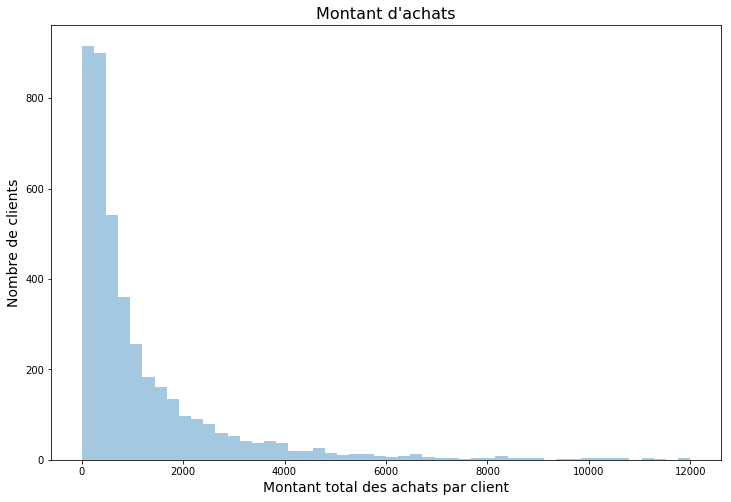

In [58]:
fig = plt.figure(figsize=(12, 8))
sns.distplot(table_rfm["Amount"], kde=False, bins=50)
plt.ylabel("Nombre de clients", fontsize=14)
plt.xlabel("Montant total des achats par client", fontsize=14)
plt.title("Montant d'achats", fontsize=16)
plt.show()

** Figure 009: ** Distribution du montant total d'achats par client.

In [59]:
table_rfm["Amount"].describe()
pd.DataFrame(table_rfm["Amount"].describe().values.reshape(1,-1),
             columns=table_rfm["Amount"].describe().index)

,count,mean,std,min,25%,50%,75%,max
0,4209.0,1181.912624,1563.875547,0.0,275.88,605.12,1441.42,11995.11


** Table descriptive de la variable Amount **: On peut voir la valeur médiane du montant d'achat est de 605 pounds.75% des clients dépensent moins de 1441,42 pounds par an.

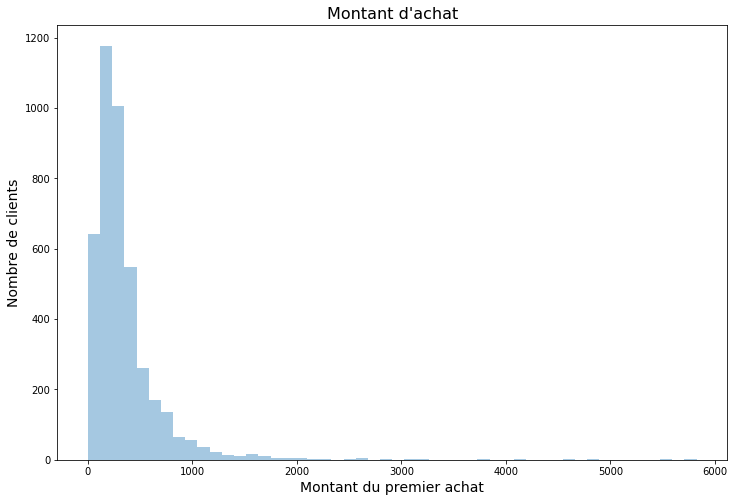

In [60]:
fig = plt.figure(figsize=(12, 8))
sns.distplot(table_rfm["Amount_first"], kde=False, bins=50)
plt.ylabel("Nombre de clients", fontsize=14)
plt.xlabel("Montant du premier achat", fontsize=14)
plt.title("Montant d'achat", fontsize=16)
plt.show()

** Figure 010: ** Distribution du montant du premier achat par client.

In [61]:
pd.DataFrame(table_rfm["Amount_first"].describe().values.reshape(1,-1),
             columns=table_rfm["Amount_first"].describe().index)

,count,mean,std,min,25%,50%,75%,max
0,4209.0,348.808877,349.969512,0.0,155.0,274.44,409.5,5825.47


** Table descriptive de la variable Amount_first: ** La valeur moyenne du premier achat est de 348,81 pounds.

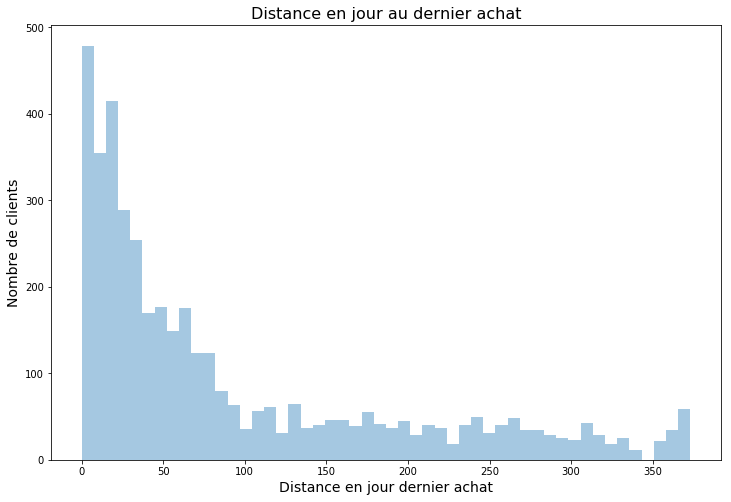

In [62]:
fig = plt.figure(figsize=(12, 8))
sns.distplot(table_rfm["Recency"], kde=False, bins=50)
plt.ylabel("Nombre de clients", fontsize=14)
plt.xlabel("Distance en jour dernier achat", fontsize=14)
plt.title("Distance en jour au dernier achat", fontsize=16)
plt.show()

** Figure 011: ** Distribution de la distance en jour au dernier achat par client.

In [63]:
pd.DataFrame(table_rfm["Recency"].describe().values.reshape(1,-1),
             columns=table_rfm["Recency"].describe().index)

,count,mean,std,min,25%,50%,75%,max
0,4209.0,93.118318,99.996814,0.0,18.0,51.0,145.0,373.0


** Table descriptive de la variable Recency **: On peut voir que la plupart des clients de la base de données sont relativement récent.

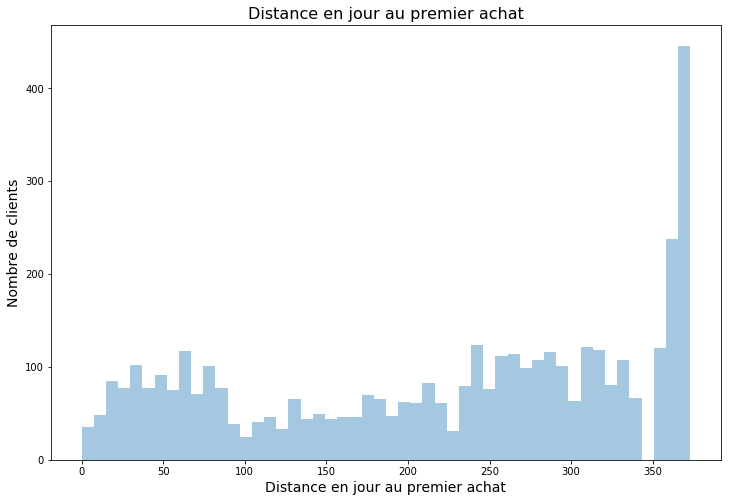

In [64]:
fig = plt.figure(figsize=(12, 8))
sns.distplot(table_rfm["Latency"], kde=False, bins=50)
plt.ylabel("Nombre de clients", fontsize=14)
plt.xlabel("Distance en jour au premier achat", fontsize=14)
plt.title("Distance en jour au premier achat", fontsize=16)
plt.show()

** Figure 012: ** Distribution de la distance en jour au premier achat par client.

In [65]:
pd.DataFrame(table_rfm["Latency"].describe().values.reshape(1,-1),
             columns=table_rfm["Latency"].describe().index)

,count,mean,std,min,25%,50%,75%,max
0,4209.0,220.08363,117.282904,0.0,109.0,246.0,322.0,373.0


** Table descriptive de la variable Latency ** : On peut voir que de nouveau clients arrivent continuement sur le site. On observe un pic au tout début de l'exercice, peut-être est-ce l'effet d'un lancement commercial.

### Analyse multivariée des features principales : ###


Nous allons passé maintenant à l'analyse du lien entre les variables de notre tableau RFM.

#### Tableau de corrélation de l'ensemble des features : ###

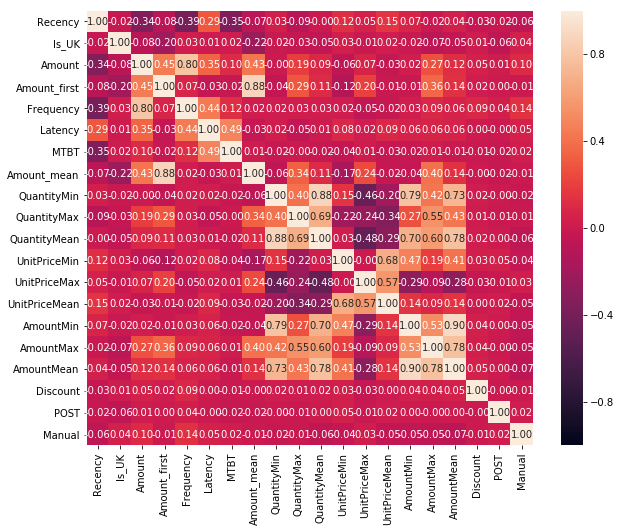

In [66]:
fig = plt.figure(figsize=(10, 8))
sns.heatmap(table_rfm.corr(), 
            vmin=-1, vmax=1, annot=True, fmt='.2f')
plt.show()

** Figure 013: ** Tableau des corrélations entre variables. On peut voir un lien entre les quantités d'achat et les prix: en général les achats de faible valeur représentent des quantités importantes. On observe également un lien fort des liens de corrélation entre les variables  Recency, Is_UK, Amount, Amount_first, Frequency, Latency et MTBT. On peut en particulier voir que la variable Amount_first est bien corrélée avec la variable Amount_mean.

#### Tableau de corrélation des features principales : ###

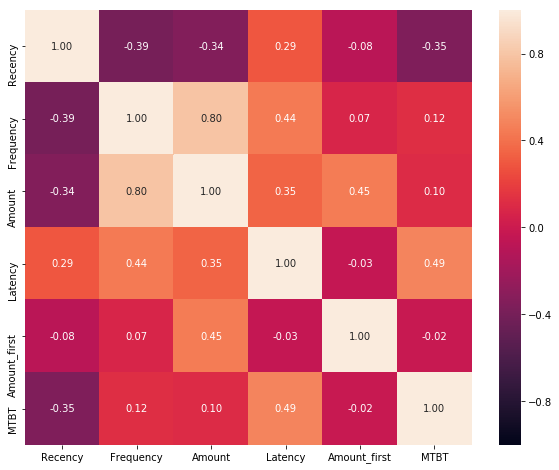

In [67]:
fig = plt.figure(figsize=(10, 8))
sns.heatmap(table_rfm[["Recency", "Frequency", "Amount", 
                        "Latency", "Amount_first", "MTBT"]].corr(), 
            vmin=-1, vmax=1, annot=True, fmt='.2f')
plt.show()

** Figure 014: ** Tableau des corrélations entre variables principales.

#### Représentation sous forme de pairplot des features principales : ####

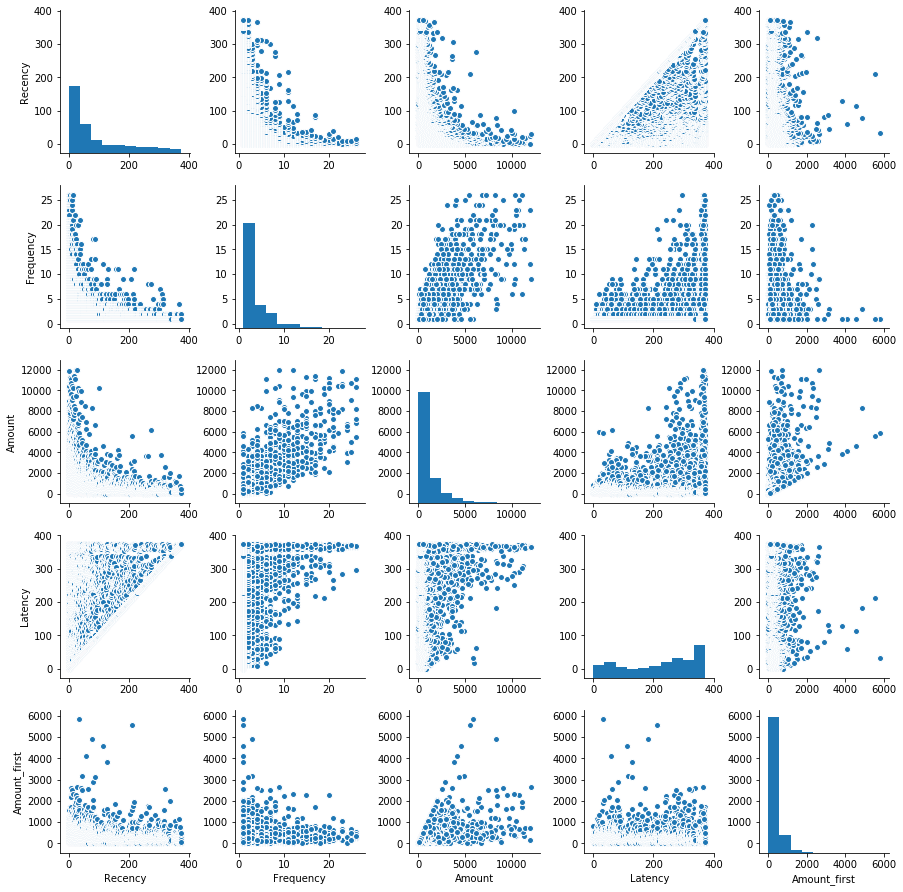

In [68]:
sns.pairplot(table_rfm[["Recency", "Frequency", "Amount", 
                        "Latency", "Amount_first"]])
plt.show()

** Figure 015: ** Représentation des liens entre les features principales.  On peut voir en particulier un lien entre Amount et Recency, on observe que ce sont les clients récents qui représentent les gros montants de transaction. 

## Clustering sur notre jeu de données RFM étendue: ##

De nombreuses essais ont été fait sur notre jeu de données afin de trouver le clustering le plus pertinent au regard du coefficient de silhouettes et de la variance intra-cluster obtenue. Nous avons finalement choisi d'inclure dans notre clustering les features Frequency, Amount, Recency, Latency, Amount_first,Is_UK, MTBT.

In [69]:
list_col = ['Frequency', 'Amount', 'Recency', 'Latency', 
            'Amount_first', "Is_UK"]

In [70]:
std_scale = preprocessing.StandardScaler().fit(table_rfm[list_col])
X_norm = std_scale.transform(table_rfm[list_col])

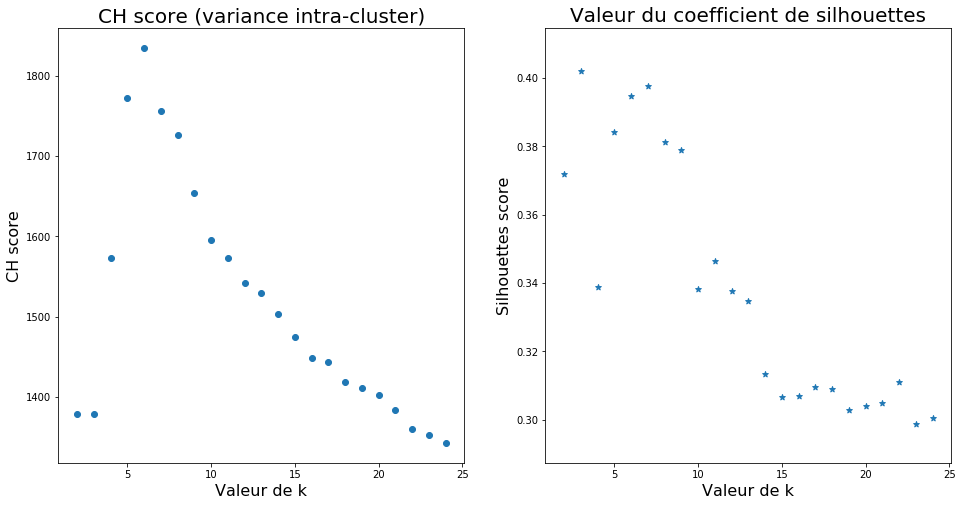

In [71]:
silhouettes = []
calinski_m = []
n_max = 25

for num_clusters in range(2, n_max):
    cls = cluster.KMeans(n_clusters=num_clusters, 
                         init='k-means++', n_init=20)
    cls.fit(X_norm)
    silh = metrics.silhouette_score(X_norm, cls.labels_)
    cal = metrics.calinski_harabaz_score(X_norm, cls.labels_)
    silhouettes.append(silh)
    calinski_m.append(cal)
    
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(121)
ax.scatter(range(2, n_max), calinski_m, marker="o")
plt.xlabel("Valeur de k", fontsize=16)
plt.ylabel("CH score", fontsize=16)
plt.title("CH score (variance intra-cluster)", fontsize=20)

ax = fig.add_subplot(122)
ax.scatter(range(2, n_max), silhouettes, marker="*")
plt.xlabel("Valeur de k", fontsize=16)
plt.ylabel("Silhouettes score", fontsize=16)
plt.title("Valeur du coefficient de silhouettes", fontsize=20)

plt.show()

** Figure 016: ** Evolution du coefficient CH et du coefficient de silhouettes en fonction des valeurs k de l'algorithme k-means.

In [72]:
cls = cluster.KMeans(n_clusters=5, n_init=300)
cls.fit(X_norm)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=300, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

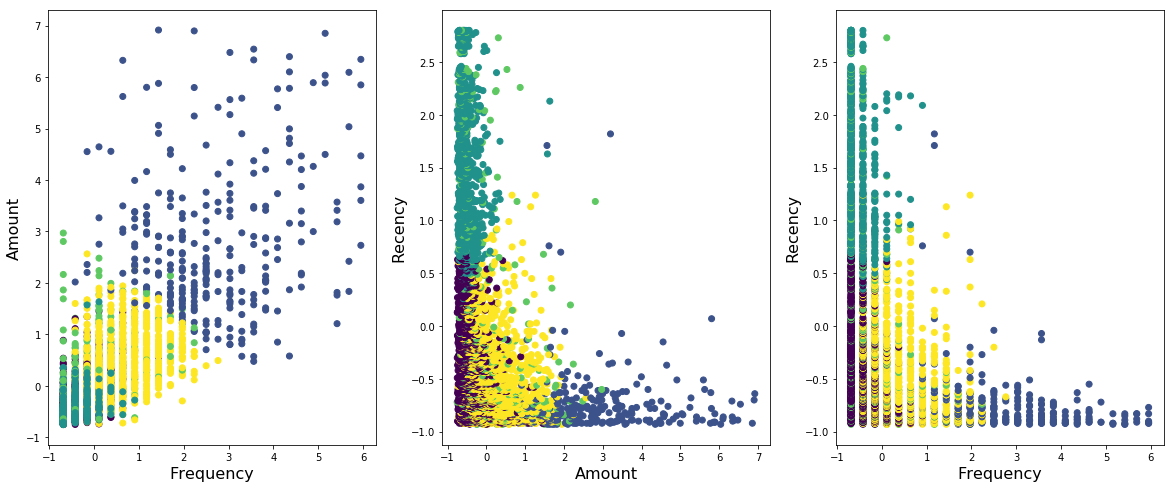

In [73]:
plot_function.afficher_2D_representation(X_norm, cls, "", "", 
                          "Frequency", "Amount", "Recency")

** Figure 017: ** Représentation du clustering obtenu dans les 3 dimensions RFM.

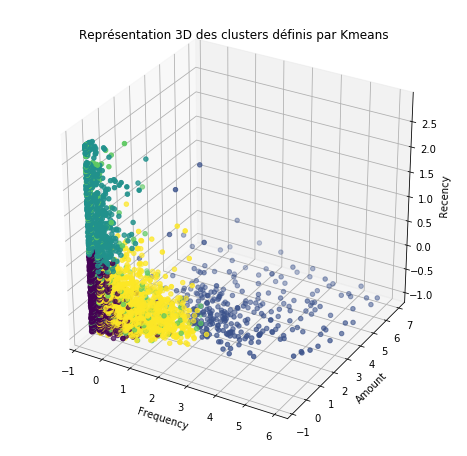

In [74]:
plot_function.afficher_3D_representation(X_norm, cls, "Kmeans",
                           "Frequency", "Amount", "Recency")

** Figure 018: ** Représentation 3D du clustering obtenu sur les données dans les dimensions RFM.

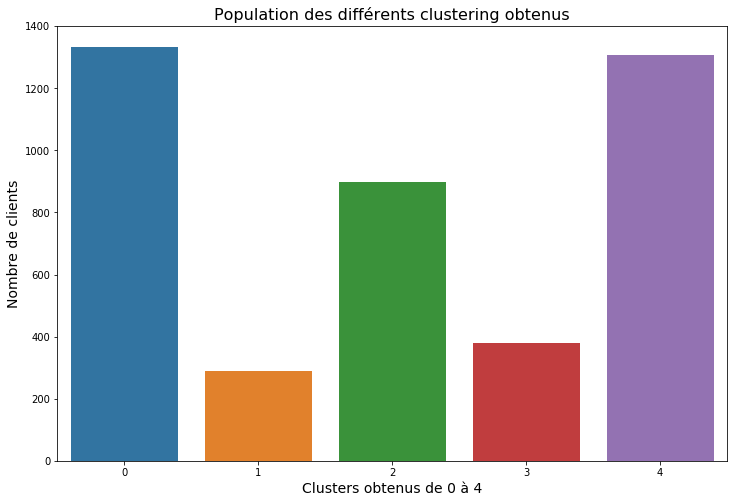

In [75]:
fig = plt.figure(figsize=(12, 8))
sns.countplot(cls.labels_)
plt.ylabel("Nombre de clients", fontsize=14)
plt.xlabel("Clusters obtenus de 0 à 4", fontsize=14)
plt.title("Population des différents clustering obtenus", fontsize=16)
plt.show()

** Figure 019: ** Représentation de la répartition de population entre les clusters obtenus. Le plus petit cluster contient 366 clients.

### Interprétation du clustering obtenu: ###

 ### Visualisation du clustering en utilisant un arbre de décision : ###

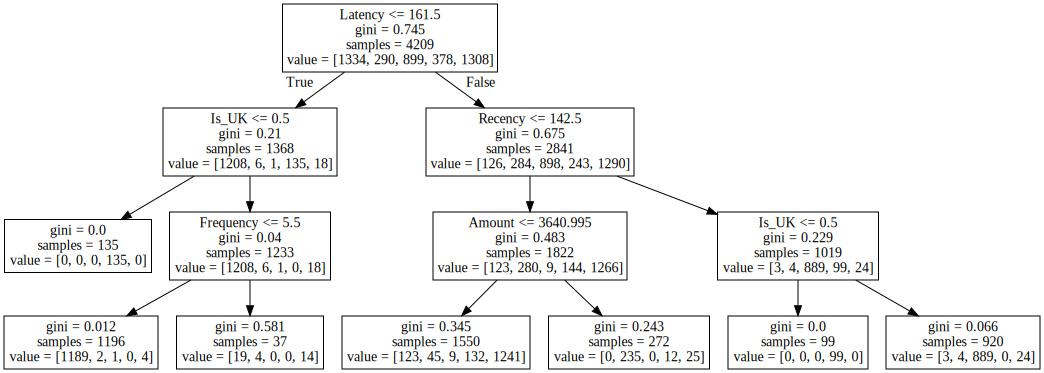

In [76]:
table_rfm["Label"] = cls.labels_
clf = tree.DecisionTreeClassifier(max_depth=3, criterion="gini")
clf.fit(table_rfm[list_col], table_rfm["Label"])
dot_data = tree.export_graphviz(clf, out_file=None, 
                               feature_names=list_col)  
graph = graphviz.Source(dot_data)  
graph 

** Figure 020: ** Arbre de décision afin d'expliquer les critères retenus pour notre clustering.

 ### Données caractérisant chaque cluster : ###

In [78]:
table_rfm.groupby(["Label"]).sum()

,Recency,Is_UK,Amount,Amount_first,Frequency,Latency,MTBT,Amount_mean,QuantityMin,QuantityMax,QuantityMean,UnitPriceMin,UnitPriceMax,UnitPriceMean,AmountMin,AmountMax,AmountMean,Discount,POST,Manual
Label,,,,,,,,,,,,,,,,,,,,
0,66257,1334,690135.952,432759.062,2366,109161,16932.563095,401895.358087,6579.419841,42555.078175,16294.147571,1111.503972,10084.335071,3704.314015,13527.231917,59141.286024,27441.382931,1,3,38
1,5280,263,1611988.410,175182.140,3991,95987,7400.209919,139283.277321,1787.294282,10853.518636,4406.212942,263.963197,2196.523035,828.303654,3978.628365,18637.050717,8359.368341,3,2,40
2,225202,899,318689.570,232931.120,1343,251442,10988.840476,222730.307095,4634.200000,24033.807143,10320.749946,1043.500810,7316.917500,2994.996914,11314.306881,39759.245119,20205.550270,0,0,22
3,39165,0,439627.280,200035.060,1027,78867,10987.414394,189728.238075,2119.625144,12086.984452,5304.466572,311.636323,2971.115113,1082.649140,4657.537618,19981.331341,9401.372345,0,5,4
4,56031,1308,1914229.022,427229.181,6368,390875,84017.510570,412021.014350,6408.402206,40683.611869,15892.767736,1151.440966,10225.030648,3798.455534,14535.289731,62679.629983,28845.910346,0,4,78


** Table descriptive de la somme des features Is_UK et Amount avec notre clustering. **

In [79]:
table_rfm.groupby(["Label"]).mean()

,Recency,Is_UK,Amount,Amount_first,Frequency,Latency,MTBT,Amount_mean,QuantityMin,QuantityMax,QuantityMean,UnitPriceMin,UnitPriceMax,UnitPriceMean,AmountMin,AmountMax,AmountMean,Discount,POST,Manual
Label,,,,,,,,,,,,,,,,,,,,
0,49.667916,1.000000,517.343292,324.407093,1.773613,81.829835,12.693076,301.270883,4.932099,31.900358,12.214503,0.833211,7.559472,2.776847,10.140354,44.333798,20.570752,0.000750,0.002249,0.028486
1,18.206897,0.906897,5558.580724,604.076345,13.762069,330.989655,25.517965,480.287163,6.163084,37.425926,15.193838,0.910218,7.574217,2.856219,13.719408,64.265692,28.825408,0.010345,0.006897,0.137931
2,250.502781,1.000000,354.493404,259.100245,1.493882,279.690768,12.223404,247.753401,5.154839,26.733935,11.480256,1.160735,8.138952,3.331476,12.585436,44.226079,22.475584,0.000000,0.000000,0.024472
3,103.611111,0.000000,1163.035132,529.193280,2.716931,208.642857,29.067234,501.926556,5.607474,31.976149,14.032980,0.824435,7.860093,2.864151,12.321528,52.860665,24.871355,0.000000,0.013228,0.010582
4,42.837156,1.000000,1463.477846,326.627814,4.868502,298.834098,64.233571,315.000775,4.899390,31.103679,12.150434,0.880307,7.817302,2.904018,11.112607,47.920206,22.053448,0.000000,0.003058,0.059633


** Table descriptive de la moyenne des features obtenues avec notre clustering.**

### Conclusion de l'interprétation et de notre segmentation client: ###

  - **groupe 0**:  Ce sont les clients récents, ils représentent un peu plus de 10% du chiffre d'affaires et ont réalisé en moyenne 1 à 2 achats durant les 3 premiers mois après le premier achat. Il s'agit d'un segment client à développer et à fidéliser car ils représentent le potentiel de croisance du CA pour l'entreprise. Ils sont de plus assez nombreux (32% des clients).
  
  - **groupe 1**: Ce sont les clients fidèles qui ont commencé très tôt à acheter sur le site et qui commandent le plus fréquemment (1 fois par mois).Ils représentent 25 % du CA pour seulement 7% de la clientèle. Il faut absolumment les conserver en leur faisant profiter de promotions (discount).
  
  - **groupe 2**: Ce sont les clients perdus, ils représentent un peu moins de 5 % du chiffre d'affaires et ont réalisé en moyenne 1 à 2 achats durant les 3 premiers mois après le premier achat. Il s'agit d'un segment de clientèle perdu depuis plus de 6 mois, il n'y a plus d'intérêt à aller faire du démarchage auprès de ces clients.Il représente 21 % des clients.
 
  - **groupe 3**: Ce sont la plus grande partie des clients étrangers, ils sont peu nombreux (9% de la clientèle) et représente 7% du CA.
 
  - **groupe 4**: Ce sont là aussi des clients fidèles, qui commandent régulièrement (1 fois tous les 2 mois), ils représentent 30% du chiffre d'affaire et 31% des clients. Sans campagne marketing, ces clients risquent d'évoluer vers groupe 1.Il faut les conserver par une campagne marketing régulière.
 

### Enregistrement des données issues de l'analyse exploratoire : ###

Nous enregistrerons le tableau final obtenu ainsi que la table rfm pour la suite de notre modélisation.

In [80]:
table_travail.to_csv("table_project_EDA.csv", sep=",", encoding='utf-8')
table_rfm.to_csv("table_rfm.csv", sep=",", encoding='utf-8')